## Assignment 4
#### https://github.com/akanyal25/CV
### Question 1

#### using the stereo cameras recognizing, tracking and estimating dimensions of an object within 3m distance

In [1]:
import math
import cv2
import webbrowser
import matplotlib.pyplot as plt
import depthai as dai
import face_recognition
import os
import numpy as np
import cv2.aruco as aruco

In [2]:
def aruco_display(corners, ids, rejected, image):

	if len(corners) > 0:
		# flatten the ArUco IDs list
		ids = ids.flatten()
		# loop over the detected ArUCo corners
		for (markerCorner, markerID) in zip(corners, ids):
			# extract the marker corners (which are always returned in
			# top-left, top-right, bottom-right, and bottom-left order)
			corners = markerCorner.reshape((4, 2))
			(topLeft, topRight, bottomRight, bottomLeft) = corners
			# convert each of the (x, y)-coordinate pairs to integers
			topRight = (int(topRight[0]), int(topRight[1]))
			bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
			bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
			topLeft = (int(topLeft[0]), int(topLeft[1]))

			cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
			cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
			cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
			cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
			# compute and draw the center (x, y)-coordinates of the ArUco
			# marker
			cX = int((topLeft[0] + bottomRight[0]) / 2.0)
			cY = int((topLeft[1] + bottomRight[1]) / 2.0)
			cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
			# draw the ArUco marker ID on the image
			cv2.putText(image, "Aruco Marker 4X4",(bottomLeft[0], bottomLeft[1] + 30), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, (0, 255, 0), 2)
			# show the output image
	return image,topLeft, topRight, bottomRight, bottomLeft

In [3]:
def getMonoCamera(pipeline, isLeft):
    mono = pipeline.createMonoCamera()

 #configure camera resolution
    mono.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)
    if isLeft:
        mono.setBoardSocket(dai.CameraBoardSocket.LEFT)
    else:
        mono.setBoardSocket(dai.CameraBoardSocket.RIGHT)
    return mono

In [4]:
def getFrame(queue):
    frame = queue.get()
    return frame.getCvFrame()

def findArucoMarkers(img, markerSize =4, totalMarkers=1000, draw=True):
    gray = img
    key = getattr(aruco, f'DICT_{markerSize}X{markerSize}_{totalMarkers}')
    arucoDict = aruco.Dictionary_get(key)
    arucoParam = aruco.DetectorParameters_create()
    # get the bounding box of the aruco markers
    corners, ids, rejected = aruco.detectMarkers(gray, arucoDict, parameters = arucoParam)
    return corners, ids, rejected


#calculating depth using disparity
def calDepth(corners1, corners2):
    focal_length = 1.636331765375964e+03 #cm
    t = 7.5 #cm
    depth = (focal_length*t)/(corners1[0][0][3][0] - corners2[0][0][3][0])
    return depth


def findDimention(depth,x1,y1,x2,y2):
    #from intrinsic matrix 
    fx = 1523.3867
    fy = 1528.6228

    #cordinates of point1
    x1 = depth*(x1/fx)
    y1 = depth*(y1/fy)

    #cordinates of point2
    x2 = depth*(x2/fx)
    y2 = depth*(y2/fy)

    #finding distance between 2 points using Euclidean distance
    dist = math.sqrt(math.pow((x2-x1),2) + math.pow((y2-y1),2))

    return dist

Left Frame


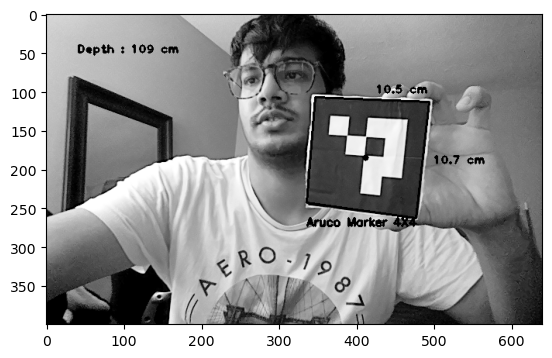

Right Frame


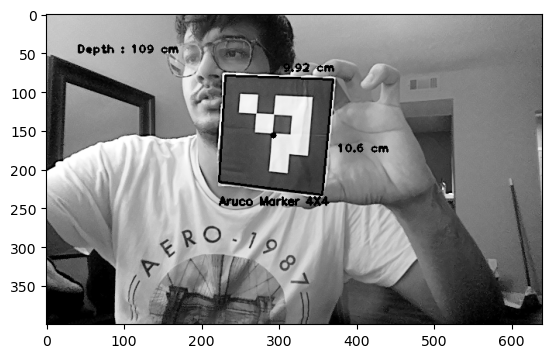

In [5]:
#create a pipeline
pipeline = dai.Pipeline()

monoLeft = getMonoCamera(pipeline, isLeft = True)
monoRight = getMonoCamera(pipeline, isLeft = False)

xoutLeft = pipeline.createXLinkOut()
xoutLeft.setStreamName("left")
xoutRight = pipeline.createXLinkOut()
xoutRight.setStreamName("right")

#Attach cameras to output XLink 
monoLeft.out.link(xoutLeft.input)
monoRight.out.link(xoutRight.input)
#pipeline is defined, now we can connect to the device
with dai.Device(pipeline, usb2Mode=True) as device:

    #get the output queues.
    leftQueue = device.getOutputQueue(name = 'left', maxSize=1)
    rightQueue = device.getOutputQueue(name = 'right', maxSize = 1)
    while True:
        leftFrame = getFrame(leftQueue)
        rightFrame = getFrame(rightQueue)

        #Getting corners
        corners1, ids, rejected = findArucoMarkers(leftFrame)
        corners2, ids, rejected= findArucoMarkers(rightFrame)
        

        #only calculate depth if corners are available
        if(len(corners1) != 0 and len(corners2) != 0):
            #marking the Aruco Frame
            leftFrame, Left_topLeft, Left_topRight, Left_bottomRight, Left_bottomLeft = aruco_display(corners1, ids, rejected, leftFrame)
            rightFrame, Right_topLeft, Right_topRight, Right_bottomRight, Right_bottomLeft = aruco_display(corners2, ids, rejected, rightFrame)

            #calculating depth
            depth = calDepth(corners1, corners2)
            output_string = "Depth : "+'{0:.3g}'.format(depth)+" cm"

            #Getting frame and corner cordinates
            Left_length_x = findDimention(depth,Left_topLeft[0],Left_topLeft[1],Left_topRight[0],Left_topRight[1])
            Left_length_y = findDimention(depth,Left_topRight[0],Left_topRight[1],Left_bottomRight[0],Left_bottomRight[1])


            Right_length_x = findDimention(depth,Right_topLeft[0],Right_topLeft[1],Right_topRight[0],Right_topRight[1])
            Right_length_y = findDimention(depth,Right_topRight[0],Right_topRight[1],Right_bottomRight[0],Right_bottomRight[1])


            #printing depth and dimentions on the frame
            output_lenX = '{0:.3g}'.format(Left_length_x)+" cm"
            output_lenY = '{0:.3g}'.format(Left_length_y)+" cm"

            cv2.putText(leftFrame,output_string, (40,50),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)
            cv2.putText(leftFrame,str(output_lenX), (int(Left_topLeft[0]+(abs(Left_topLeft[0]-Left_topRight[0])/2))+5,(Left_topLeft[1]-5)),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)
            cv2.putText(leftFrame,str(output_lenY), ((Left_topRight[0])+5, int(Left_topRight[1]+(abs(Left_bottomRight[1]-Left_topRight[1])/2)+5)),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)


            output_lenX = '{0:.3g}'.format(Right_length_x)+" cm"
            output_lenY = '{0:.3g}'.format(Right_length_y)+" cm"

            cv2.putText(rightFrame,output_string, (40,50),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)
            cv2.putText(rightFrame,str(output_lenX), (int(Right_topLeft[0]+(abs(Right_topLeft[0]-Right_topRight[0])/2))+5,(Right_topLeft[1]-5)),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)
            cv2.putText(rightFrame,str(output_lenY), ((Right_topRight[0])+5, int(Right_topRight[1]+(abs(Right_bottomRight[1]-Right_topRight[1])/2)+20)),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)


        cv2.imshow('left', leftFrame)
        cv2.imshow('right', rightFrame)

        key = cv2.waitKey(1)
        if key == ord('q'):
            break 
        elif key == ord('p'):
            leftFrame = cv2.cvtColor(leftFrame, cv2.COLOR_BGR2RGB)
            print("Left Frame")
            plt.imshow(leftFrame)
            plt.show()
            rightFrame = cv2.cvtColor(rightFrame, cv2.COLOR_BGR2RGB)
            print("Right Frame")
            plt.imshow(rightFrame)
            plt.show()
cv2.destroyAllWindows()

### Question 2
#### “smart” business/visiting card

In [6]:
classNames = []
encodeListKnown = []

In [7]:
def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

def encode():
    path = './Q2/Faces'
    images = []
    global classNames
    global encodeListKnown
    myList = os.listdir(path)
    print(myList)
    for cl in myList:
        curImg = cv2.imread(f'{path}/{cl}')
        images.append(curImg)
        classNames.append(os.path.splitext(cl)[0])
    print(classNames)
    encodeListKnown = findEncodings(images)
    print('Encoding Complete')  

In [8]:
def facereg(img):
    face_locations = []
    face_encodings = []
    face_names = []
    frame = img
    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)


        # Find all the faces and face encodings in the current frame of video
    face_locations = face_recognition.face_locations(rgb_small_frame,number_of_times_to_upsample=2)
        # model='cnn'
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

    face_names = []
    for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(encodeListKnown, face_encoding)
        name = "Unknown"

            # # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(encodeListKnown, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = classNames[best_match_index]
        if name != "Unknown":
            face_names.append(name)


        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            face_scrape = []

            for pers in face_names:
                if not pers=="Unknown":
                    face_scrape.append(pers)

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # return recognised faces and names
    return face_names, frame

In [9]:
data_dictionary = {
  "faces": [
    {
      "firstname": "Ayush",
      "lastname": "Kanyal",
      "type": "Student",
      "Department": "CS",
      "email": "akanyal1@student.gsu.edu",
      "link": "https://github.com/akanyal25/CV"
    },
    {
      "firstname": "Ashwin",
      "lastname": "Ashok",
      "type": "Faculty",
      "Department": "CS",
      "email": "aashok@gsu.edu",
      "link": "https://mobile.cs.gsu.edu/aashok/"
    }]
}

In [20]:
firstname = None
lastname= None
type= None
Department= None
email= None,
link=None

In [11]:
#calling encode to get the face encodings from the images
encode()

['Ashwin.jpg', 'Ayush.jpeg']
['Ashwin', 'Ayush']
Encoding Complete


In [12]:
def getData(name):

    for person in data_dictionary["faces"]:
        if(person["firstname"]==name):
            global firstname,lastname,type,Department,email,link 
            firstname,lastname,type,Department,email,link = person["firstname"],person["lastname"],person["type"],person["Department"],person["email"],person["link"]


In [13]:
def QR(img):
    # initialize the cv2 QRCode detector
    detector = cv2.QRCodeDetector()

    data, bbox, _ = detector.detectAndDecode(img)
    a = data
    # check if there is a QRCode in the image
    if data:
        a=data
        img = cv2.rectangle(img,(int(bbox[0][0][0]),int(bbox[0][0][1])),(int(bbox[0][2][0]),int(bbox[0][2][1])), (0,255,0), 2)
        
    return img, a

In [15]:
#depthai camera setup
def getMonoCamera(pipeline):
    mono = pipeline.createMonoCamera()

 #configure camera resolution
    mono.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)
    mono.setBoardSocket(dai.CameraBoardSocket.LEFT)
    return mono

def getFrame(queue):
    frame = queue.get()
    return frame.getCvFrame()

#create a pipeline
pipeline = dai.Pipeline()

monoLeft = getMonoCamera(pipeline)


xoutLeft = pipeline.createXLinkOut()
xoutLeft.setStreamName("left")


#Attach cameras to output XLink 
monoLeft.out.link(xoutLeft.input)


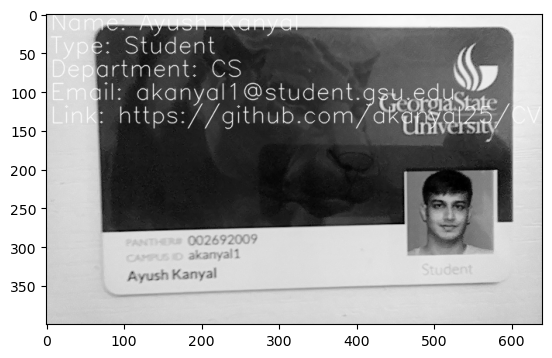

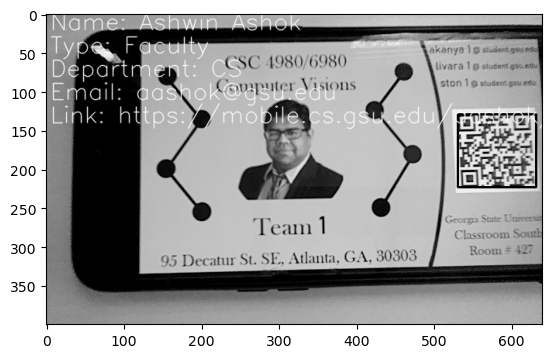

https://cas.gsu.edu/profile/ashwin-ashok/



In [21]:
# Connect to device and start pipeline
with dai.Device(pipeline, usb2Mode=True) as device:

    #get the output queues.
    leftQueue = device.getOutputQueue(name = 'left', maxSize=1)
    a = None
    nextLink = 0
    while True:
        img = getFrame(leftQueue)
        
        retImg, a = QR(img)

        if a:
            img = retImg
            nextLink = a
        # Get BGR frame from NV12 encoded video frame to show with opencv
        # Visualizing the frame on slower hosts might have overhead

        face_names, frame = facereg(retImg)

        for name in face_names:
            if(name == "Unknown"):
                continue
            getData(name)
        if firstname != None:
            cv2.putText(frame, "Name: "+firstname+" "+lastname, (5,20),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  1, cv2.LINE_AA)
            cv2.putText(frame, "Type: "+type, (5,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  1, cv2.LINE_AA)
            cv2.putText(frame, "Department: "+ Department, (5,80),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  1, cv2.LINE_AA)
            cv2.putText(frame, "Email: "+email, (5,110),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  1, cv2.LINE_AA)
            cv2.putText(frame, "Link: "+link, (5,140),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  1, cv2.LINE_AA)


        cv2.imshow("video", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            if nextLink != 0 :
                print(nextLink)
                print("")
                b = webbrowser.open(str(nextLink))
            break
        elif key == ord('p'):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
            plt.show()



cv2.destroyAllWindows()